In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"

## A very simple example

0.0019352874999999927


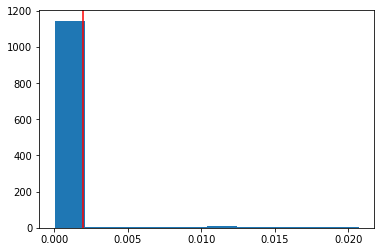

In [2]:
file = open(f'{datadir}/improve_C.pkl', 'rb')
out = pickle.load(file)
file.close()


X = out["X"]
Ftrue = out["Ftrue"]
Ltrue = out["Ltrue"]
Pi_true = out["Pi_true"]
Pi_eb = out["Pi"]
AB = out["AB"]
k = 3 ## forgot to store
n, p = X.shape

## truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n

## naive Cbar
Cbar1 = C / C.sum(axis = 1)[:, None] 

## apply EB shrinkage to estimate Pi, then construct CBar
Cbar2 = Pi_eb.T @ Pi_eb / n
Cbar2 /= Cbar2.sum(axis = 1)[:, None]

## Cbar without scaling C
Cbar3 = C / C.sum(axis = 1).max()

## C scaled with a cutoff
d = C.sum(axis = 1)
cutoff = np.quantile(d, [0.953])[0] ## need a more principled way to do this!!
d[d < cutoff] = cutoff
Cbar4 = C / d[:, None]

print(cutoff)
plt.hist(C.sum(axis = 1))
plt.axvline(x=cutoff, color = "red")
plt.show()

In [3]:
%%capture

S0, _, _ = findS(Cbar0, k)
S1, _, _ = findS(Cbar1, k)
S2, _, _ = findS(Cbar2, k)
S3, _, _ = findS(Cbar3, k)
S4, _, _ = findS(Cbar4, k)

Cbar0_pj = pca_proj(Cbar0)
Cbar1_pj = pca_proj(Cbar1)
Cbar2_pj = pca_proj(Cbar2)
Cbar3_pj = pca_proj(Cbar3)
Cbar4_pj = pca_proj(Cbar4)

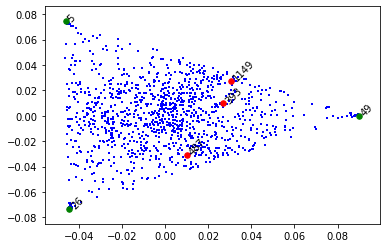

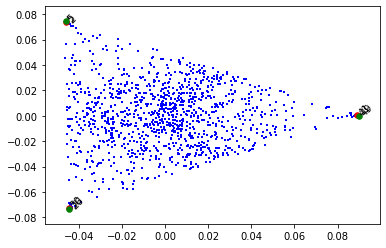

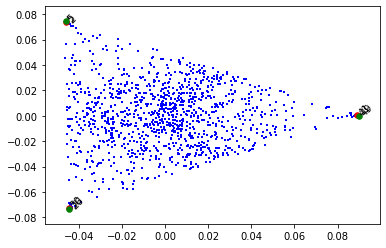

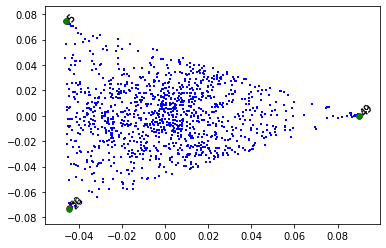

In [4]:
which_dim = [0, 1]
vis_extremal2(Cbar0_pj, S0, S1, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar0_pj, S0, S2, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar0_pj, S0, S3, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar0_pj, S0, S4, which_dim = which_dim, annotate=True,fontsize=10)

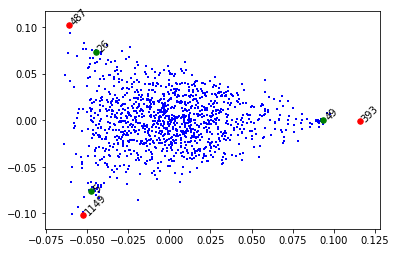

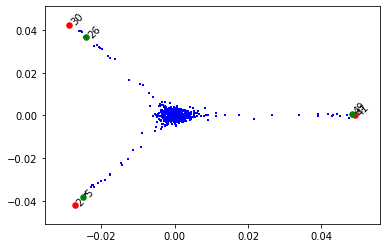

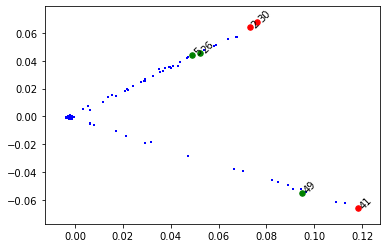

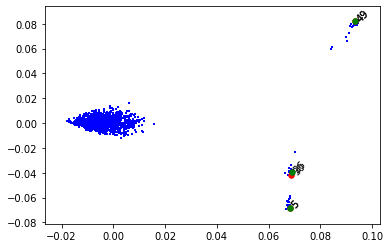

In [5]:
which_dim = [0, 1]
vis_extremal2(Cbar1_pj, S0, S1, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar2_pj, S0, S2, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar3_pj, S0, S3, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar4_pj, S0, S4, which_dim = which_dim, annotate=True,fontsize=10)

Look at "true" $\bar{C}^{(4)}$

In [6]:
%%capture
Cbar4_true = Ctrue / d[:, None]
Cbar4_true_pj = pca_proj(Cbar4_true)
S40, _, _ = findS(Cbar4_true, k)

In [7]:
%matplotlib widget

coords = Cbar4_true_pj

extremal = np.append(np.zeros((1, coords.shape[1])), coords[S40,:], axis = 0)[:, :3]

x, y, z = extremal[:,0],extremal[:,1], extremal[:,2]
vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

tupleList = list(zip(x, y, z))
poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]

poly3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, color = "red", s = 50)
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))

x2 = coords[:, 0]
y2 = coords[:, 1]
z2 = coords[:, 2]


ax.scatter(x2, y2, z2, s = 5, 
        cmap='viridis', linewidth=0.5);

ax.set_xlim(coords[:, 0].min(),coords[:, 0].max())
ax.set_ylim(coords[:, 1].min(),coords[:, 1].max())
ax.set_zlim(coords[:, 2].min(),coords[:, 2].max())

ax.text(0, 0, 0, "0")

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
vis_extremal2(Cbar4_true_pj, S40, S4, [0, 1], annotate=True,fontsize=10)
vis_extremal2(Cbar4_true_pj, S40, S4, [1, 2],annotate=True,fontsize=10)

# vis_extremal2(Cbar4_true_pj, S40, S4, [2, 3], annotate=True,fontsize=10)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## More realistic example

In [9]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
file = open(f'{datadir}/improve_C2.pkl', 'rb')
out = pickle.load(file)
file.close()

X = fitted['X'].toarray()
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']


Pi_true = Ltrue @ Ftrue.T
Pi_eb = out["Pi"]
AB = out["AB"]
n, p = X.shape




In [10]:
## truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

## naive Cbar
Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n
Cbar1 = C / C.sum(axis = 1)[:, None] 

## apply EB shrinkage to estimate Pi, then construct CBar
Cbar2 = Pi_eb.T @ Pi_eb / n
Cbar2 /= Cbar2.sum(axis = 1)[:, None]

## Cbar without scaling C
d = C.sum(axis = 1)
Cbar3 = C / d.max()

## C scaled with a cutoff
cutoff = np.quantile(d, [0.98])[0] ## need a more principled way to do this!!
d[d < cutoff] = cutoff
Cbar4 = C / d[:, None]

print(cutoff)
plt.hist(C.sum(axis = 1))
plt.axvline(x=cutoff, color = "red")
plt.show()

0.0011210989029978898


In [11]:
%%capture

S0, _, _ = findS(Cbar0, k)
S1, _, _ = findS(Cbar1, k)
S2, _, _ = findS(Cbar2, k)
S3, _, _ = findS(Cbar3, k)
S4, _, _ = findS(Cbar4, k)

Cbar0_pj = pca_proj(Cbar0)
Cbar1_pj = pca_proj(Cbar1)
Cbar2_pj = pca_proj(Cbar2)
Cbar3_pj = pca_proj(Cbar3)
Cbar4_pj = pca_proj(Cbar4)

In [12]:
which_dim = [0, 1]
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S1, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S2, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S3, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S4, which_dim = which_dim, annotate=True,fontsize=10)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
which_dim = [0, 1]
vis_extremal2(Cbar1_pj, S0, S1, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar2_pj, S0, S2, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar3_pj, S0, S3, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal2(Cbar4_pj, S0, S4, which_dim = which_dim, annotate=True,fontsize=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
vis_extremal2(Cbar4_pj, S0, S4, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal2(Cbar4_pj, S0, S4, which_dim = [4, 5], annotate=True,fontsize=10)
vis_extremal2(Cbar4_pj, S0, S4, which_dim = [6, 7], annotate=True,fontsize=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### understand what $\bar{C}^{(4)}$ looks like

In [15]:
%%capture
Cbar4_true = Ctrue / d[:, None]
Cbar4_true_pj = pca_proj(Cbar4_true)
S40, _, _ = findS(Cbar4_true, k)

In [16]:
vis_extremal2(Cbar4_true_pj, S40, S4, [0, 1], annotate=True,fontsize=10)
vis_extremal2(Cbar4_true_pj, S40, S4, [2, 3], annotate=True,fontsize=10)
vis_extremal2(Cbar4_true_pj, S40, S4, [4, 5], annotate=True,fontsize=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …